# Introduction to Mean-CVaR Optimization

This notebook introduces NVIDIA's GPU-Accelerated Portfolio Optimization developer blueprint. We use the Mean-CVaR model to solve the problem of portfolio asset allocation. We show step-by-step how to pre-process input data, build the optimization model, solve the problem, and backtest the portfolio performance.
In particular, we will cover the following in this notebook: 
- Portfolio Optimization Setup – Import necessary libraries and configure solver settings.
- Data-preprocessing - calculate daily returns from input price data 
- Scenario generation - use cuML KDE to model returns distribution and generate return scenarios 
- Model Building - build the optimization problem with optional constraints
- Solving Optimization on GPU – call GPU/CPU solvers with customizable settings to solve the problem
- Backtesting - visualize and evaluate optimized portfolio
- Comparing CPU and GPU Performance – evaluate performance solving optimization problem on GPU vs CPU.


Before diving into portfolio optimization, we need to import the necessary libraries and perform initial setup if required.

In [1]:
import subprocess
import html
from IPython.display import display, HTML

def check_gpu():
    try:
        result = subprocess.run(["nvidia-smi"], capture_output=True, text=True, timeout=5)
        result.check_returncode()
        lines = result.stdout.splitlines()
        gpu_info = lines[2] if len(lines) > 2 else "GPU detected"
        gpu_info_escaped = html.escape(gpu_info)
        display(HTML(f"""
        <div style="border:2px solid #4CAF50;padding:10px;border-radius:10px;background:#e8f5e9;">
            <h3>✅ GPU is enabled</h3>
            <pre>{gpu_info_escaped}</pre>
        </div>
        """))
        return True
    except (subprocess.CalledProcessError, subprocess.TimeoutExpired, FileNotFoundError, IndexError) as e:
        display(HTML("""
        <div style="border:2px solid red;padding:15px;border-radius:10px;background:#ffeeee;">
            <h3>⚠️ GPU not detected!</h3>
            <p>This notebook requires a <b>GPU runtime</b>.</p>
            
            <h4>If running in Google Colab:</h4>
            <ol>
              <li>Click on <b>Runtime → Change runtime type</b></li>
              <li>Set <b>Hardware accelerator</b> to <b>GPU</b></li>
              <li>Then click <b>Save</b> and <b>Runtime → Restart runtime</b>.</li>
            </ol>
            
            <h4>If running in Docker:</h4>
            <ol>
              <li>Ensure you have <b>NVIDIA Docker runtime</b> installed (<code>nvidia-docker2</code>)</li>
              <li>Run container with GPU support: <code>docker run --gpus all ...</code></li>
              <li>Or use: <code>docker run --runtime=nvidia ...</code> for older Docker versions</li>
              <li>Verify GPU access: <code>docker run --gpus all nvidia/cuda:12.0.0-base-ubuntu22.04 nvidia-smi</code></li>
            </ol>
            
            <p><b>Additional resources:</b></p>
            <ul>
              <li><a href="https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html" target="_blank">NVIDIA Container Toolkit Installation Guide</a></li>
            </ul>
        </div>
        """))
        return False

check_gpu()

True

In [2]:
import os
from cufolio import cvar_optimizer, cvar_utils, utils
from cufolio.cvar_parameters import CvarParameters
import cvxpy as cp

# Build a Mean-CVaR problem

The Mean-CVaR model captures the risk-return trade-off, aiming to maximize expected return while minimizing Conditional Value-at-Risk. 

Traditionally, variance of portfolio returns is used as the measure of risk. Here, we use Conditional Value-at-Risk (CVaR) as an alternative risk measure because it provides a more robust assessment of potential tail losses, and allows a data-driven approach to portfolio optimization without making assumptions on the underlying returns distribution. CVaR measures the average worst-case loss of a return distribution. Formally, for a loss random variable L,
$$CVaR = \mathbf{E}[L| L \leq VaR_\alpha (L)]$$
where  $VaR(L) = \inf{l: P(L \leq l) \geq \alpha  }$ is the $\alpha$-quantile of the loss distribution. CVaR is a more appropriate risk measure for portfolios that may contain assets with asymmetric return distribution - it has replaced Value-at-Risk(VaR) in Basel III market-risk rules; Mathematically, CVaR is a coherent risk measure—satisfying subadditivity, translation invariance, positive homogeneity, and monotonicity—which aligns with the diversification principles. Moreover, it has a computationally tractable transformation as a scenario-based optimization: for confidence level , the CVaR of portfolio w can be written in abstract form as 
$$CVaR(w) = \min_t\left\{t + \frac{1}{1-\alpha}\sum_{\omega \in \Omega}p(\omega)\max \{loss(w,\omega) - t, 0\}\right\}, $$
where $\Omega$ is the probability space of returns scenarios and $p(\omega)$ is the probability of a particular scenario $\omega \in \Omega$. Intuitively, this expression represents the portfolio’s average loss below the $\alpha$-quantile of all return scenarios. This scenario-based formulation makes CVaR more robust regardless whether the asset returns distribution is Gaussian or not. When we use linear loss, i.e. $loss(w,\omega) = -R(\omega)w$, with $R$ as the return scenarios matrix of size (num_scenarios, num_assets),  the minimization of the CVaR can be transformed into a linear program by replacing the $\max{\cdot,0}$ non-negative operator with an auxiliary variable $u$: 

\begin{align*}
&\text{max: } \mu^\top w - \lambda_{risk}\left(t + \frac{1}{1-\alpha}p^\top \mathbf{u}\right),\\
&\text{subject to: } \mathbf{u} \geq -R^\top \mathbf{w} - t.\\
\end{align*}



Then, we add constraints to model real-world trading limitations:
- Concentration limits on single assets
- Amount invested in risk-free assets (cash)
- Investment budgets
- Leverage constraints
- Turnover from an existing portfolio
- Cardinality constraints (maximum number of assets allowed in the portfolio)


The mathematical formulation of the problem is given as follows: 
\begin{align}
\text{max: } &\mu^\top w - \lambda_{risk}\left(t + \frac{1}{1-\alpha}p^\top \mathbf{u}\right),\\
\text{subject to: } & \mathbf{1}^\top \mathbf{w} = 1,\\
&\mathbf{u} \geq -R^\top \mathbf{w} - t,\\
& \mathbf{w}^{\min} \circ \mathbf{y} \leq \mathbf{w} \leq \mathbf{w}^{\max} \circ y, c^{\min} \leq c \leq c^{\max},\\
& L= \Vert \mathbf{w} \Vert_1 \leq L^{tar},\\
& T = \Vert \mathbf{w} - \mathbf{w}_{b}\Vert_1 \leq T^{tar},\\
& \sum{\mathbf{y}} \leq K,\\
&y_i \in \{0,1\}^N.
\end{align}

## Data Preprocessing and Model Setup
We start with an example using a 397-stock subset of the S&P 500 stocks. We aim to build a long-short portfolio that maximizes risk-adjusted returns while meeting custom trading constraints. 

### 1. Define Problem Parameters
We define a `CvarParameters` object to encapsulate key constraints and settings for our portfolio optimization pipeline. This object configures the Mean-CVaR model with both required and optional parameters:

Required parameters: Settings like `w_min`, `w_max`, `risk_aversion`, `confidence`, `num_scen`, and `fit_type` must be specified to establish the basic optimization framework.

Optional constraints: Parameters such as `T_tar` (turnover constraint), `cvar_limit` (maximum CVaR threshold), and `cardinality` (portfolio size limit) are optional. Setting any of these to a non-`None` value will add the corresponding constraint to the Mean-CVaR model.

In [ ]:
# Define CVaR optimization parameters for the S&P 500 example
cvar_params = CvarParameters(
    w_min={"NVDA":0.1, "others": -0.3}, w_max={"NVDA": 0.6, "others": 0.4},  # Asset weight allocation bounds {ticker str: weight}
    c_min = 0.0, c_max = 0.2,         # Cash holdings bounds
    L_tar = 1.6, T_tar = None,        # Leverage & Turnover (None for this example)
    cvar_limit = None,                # Max CVaR (None = unconstrained for this example)
    cardinality = None,               # Cardinality constraints
    risk_aversion= 1,                 # Risk aversion level
    confidence = 0.95,                # CVaR confidence level (alpha)
    num_scen = 10000,                 # Number of return scenarios to simulate
    fit_type = "kde"                  # Return distribution estimation method
)

### 2. Data Preparation

We load closing prices from `2021-01-01` to `2024-01-01` and compute daily log‐returns. Next, we use the Kernel Density Estimator (KDE) to fit the returns and simulate  `cvar_params.num_scen` return scenarios. 

Key Components:

- Return Type (r`eturn_type`): "LOG" for log-returns.
- Historical Dataset (`data_path`): CSV file with adjusted closing prices.
- Regime Information (`regime_dict`): select the market regime (assuming that ).
- Scenario Generation: use `cuml.KDE` on GPU or `sklearn.KDE` on CPU to fit return distribution and sample scenarios.

In [ ]:
# --- User inputs for S&P 500 Example ---
dataset_name = "sp500"
dataset_format = "csv"

return_type = "LOG"
kde_device = "GPU"       # Device for KDE computation ("GPU" or "CPU")

# Set date range and file path
scenario_name = "recent" 
time_range = ("2021-01-01", "2024-01-01")
data_path = f"../data/stock_data/{dataset_name}.{dataset_format}"


# Define the regime for this example
regime_dict = {"name": scenario_name, "range": time_range}

# Compute returns for the S&P 500 example
returns_dict = cvar_utils.calculate_returns(
    data_path,
    regime_dict,
    return_type,
    cvar_params,         # CVaR parameters defined for this example
    device=kde_device
)

### 3. Build Mean-CVaR Problem
We take the processed data `returns_dict` and the problem parameters `cvar_params` and formulates the problem `cvar_problem`. 


In [6]:
# Instantiate CVaR optimization problem for the S&P 500 example
cvar_problem = cvar_optimizer.CVaR(
    returns_dict=returns_dict,
    cvar_params=cvar_params
)

## Solve CVaR Optimization

### 1. cuOpt GPU Solver
We then call the cuOpt LP solver and returns the optimized portfolio. One may also provide customized configurations to the cuOpt LP solver including solver mode, accuracy, etc. 

cuOpt LP solver supports four solve methods: choose one of the following by setting `solver_method`: 
1. PDLP algorithm has three solver modes: choose one of the following by setting `solver_mode`:
    - "Stable2": balance speed and accuracy
    - "Methodical1": prioritize accuracy
    - "Fast1": prioritize speed

2. Dual Simplex
3. Barrier Method
4. Concurrent: runs all three algorithms and return the fastest.

For details, see cuOpt documentation: https://docs.nvidia.com/cuopt/user-guide/latest/introduction.html.


In [ ]:
# GPU solver settings
gpu_solver_settings = {"solver": cp.CUOPT, "verbose": True, 
                       "solver_method": "PDLP", 
                       "solver_mode": "Stable2", 
                       "time_limit":15, 
                       "optimality": 1e-4
                       }

# solve on GPU
gpu_results, gpu_portfolio = cvar_problem.solve_optimization_problem(solver_settings=gpu_solver_settings)

(CVXPY) Nov 05 02:37:50 AM: Your problem has 10399 variables, 10002 constraints, and 2 parameters.
(CVXPY) Nov 05 02:37:50 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 05 02:37:50 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 05 02:37:50 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Nov 05 02:37:50 AM: Using cached ASA map, for faster compilation (bypassing reduction chain).
(CVXPY) Nov 05 02:37:50 AM: Finished problem compilation (took 5.600e-02 seconds).
(CVXPY) Nov 05 02:37:50 AM: Invoking solver CUOPT  to obtain a solution.


                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------


(CVXPY) Nov 05 02:37:51 AM: Problem status: optimal
(CVXPY) Nov 05 02:37:51 AM: Optimal value: -1.366e-03
(CVXPY) Nov 05 02:37:51 AM: Compilation took 5.600e-02 seconds
(CVXPY) Nov 05 02:37:51 AM: Solver (including time spent in interface) took 4.533e-01 seconds


Setting parameter log_to_console to true
Setting parameter method to 1
Setting parameter absolute_dual_tolerance to 1.000000e-04
Setting parameter relative_dual_tolerance to 1.000000e-04
Setting parameter absolute_primal_tolerance to 1.000000e-04
Setting parameter relative_primal_tolerance to 1.000000e-04
Setting parameter absolute_gap_tolerance to 1.000000e-04
Setting parameter relative_gap_tolerance to 1.000000e-04
Setting parameter time_limit to 1.500000e+01
cuOpt version: 25.10.0, git hash: 99e549c, host arch: x86_64, device archs: 75-real,80-real,86-real,90a-real,100f-real,120a-real,120
CPU: Intel(R) Xeon(R) Platinum 8480C, threads (physical/logical): 112/224, RAM: 1679.62 GiB
CUDA 13.0, device: NVIDIA H200 (ID 0), VRAM: 139.80 GiB
CUDA device UUID: 64fffffff0ffffffcdffffff8a-0cfffffff

Solving a problem with 10796 constraints, 10796 variables (0 integers), and 3992383 nonzeros
Problem scaling:
Objective coefficents range:          [6e-07, 5e-02]
Constraint matrix coefficients ran

### Optional: Visualize Optimized Portfolio

Portfolio plot saved: ../result/portfolio/


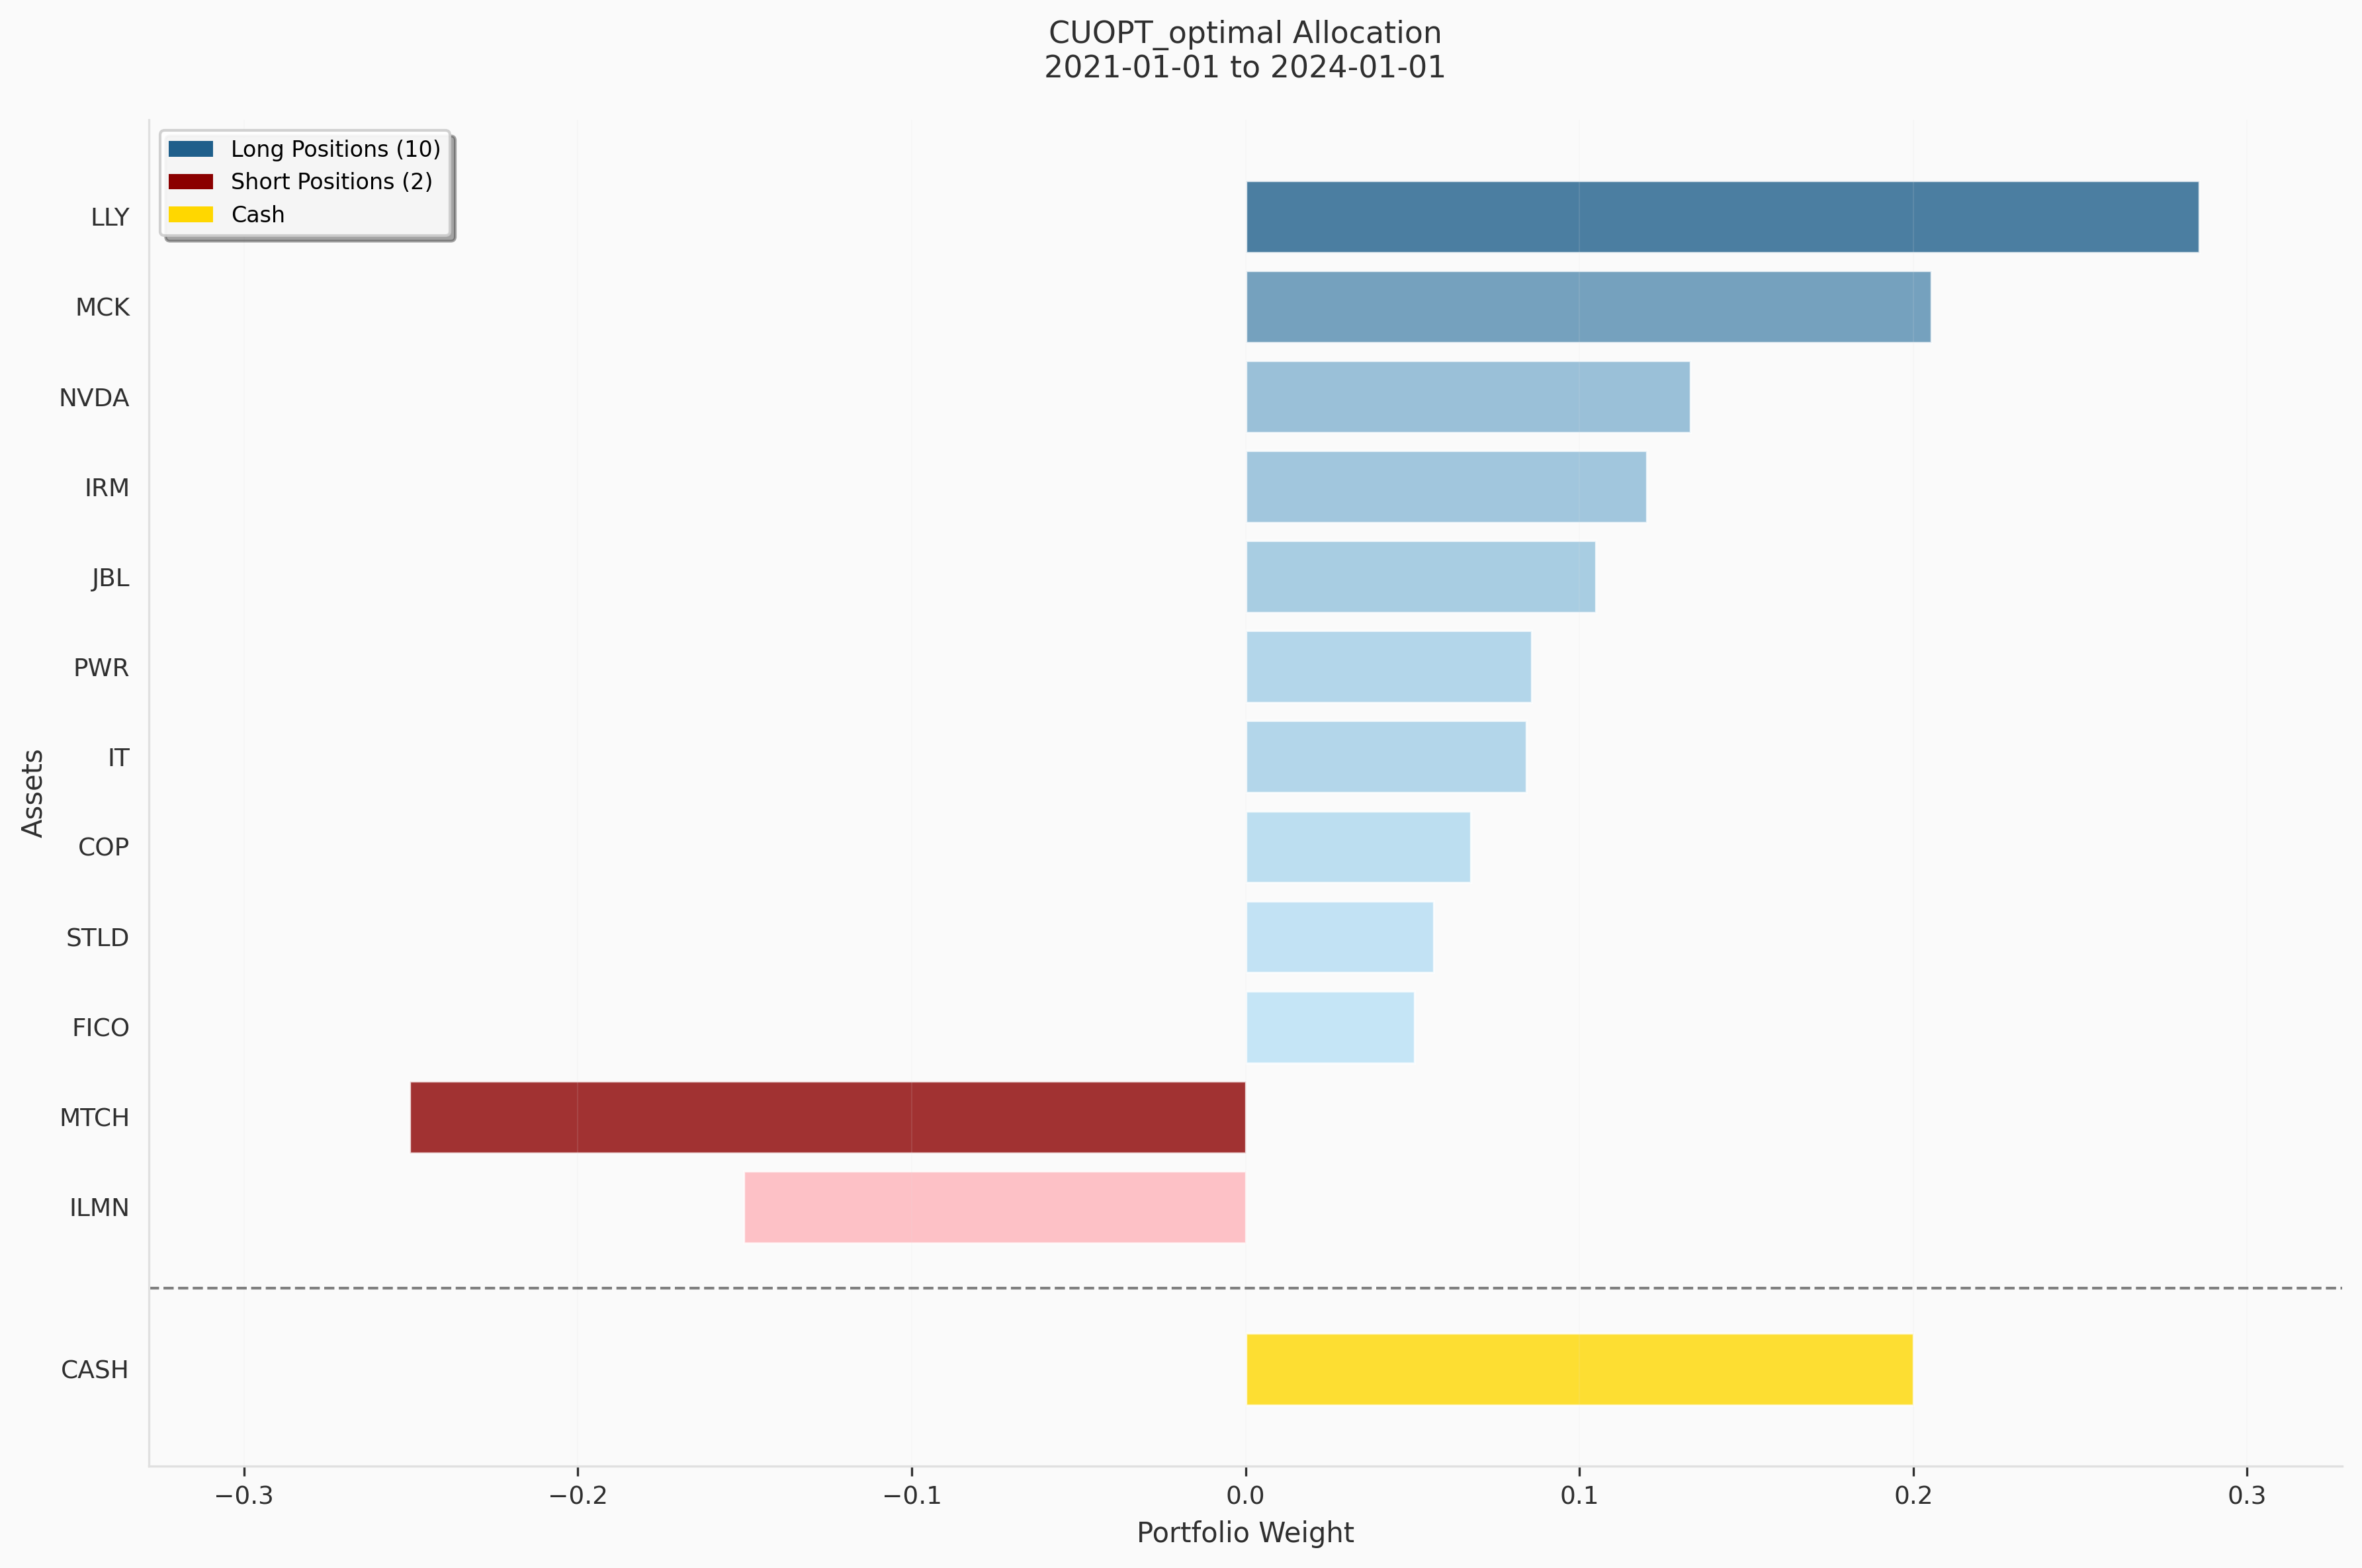

In [ ]:
# plot portfolio and save the plot
ax = gpu_portfolio.plot_portfolio(show_plot = True, min_percentage = 1, save_path = "../result/portfolio/")

### Solve on CPU solver
Use CVXPY as the modeling API and we can easily change to any CPU solver supported on CVXPY by changing the solver in the solver settings dictionary.

In [ ]:
cvar_problem = cvar_optimizer.CVaR(
    returns_dict=returns_dict,
    cvar_params=cvar_params,
    api_settings={"api": "cvxpy"}
)

#CPU solver settings
cpu_solver_settings = {"solver":cp.HIGHS, "verbose": False, "highs_options": {"solver":"simplex"}}
#solve on CPU
cpu_results, cpu_portfolio = cvar_problem.solve_optimization_problem(solver_settings=cpu_solver_settings)


CVaR OPTIMIZATION RESULTS
PROBLEM CONFIGURATION
------------------------------
Solver:              HIGHS
Regime:              recent
Time Period:         2021-01-01 to 2024-01-01
Scenarios:           20,000
Assets:              397
Confidence Level:    95.0%

PERFORMANCE METRICS
------------------------------
Expected Return:     0.002517 (0.2517%)
CVaR (95%):          0.023755 (2.3755%)
Objective Value:     -0.001393

SOLVING PERFORMANCE
------------------------------
Setup Time:          0.5067 seconds
CVXPY API Overhead:  1.0796 seconds
Solve Time:          68.1519 seconds

OPTIMAL PORTFOLIO ALLOCATION
------------------------------

PORTFOLIO: HIGHS_OPTIMAL
----------------------------------------
Period: 2021-01-01 to 2024-01-01

LONG POSITIONS (11 assets)
-------------------------
LLY         0.301 ( 30.08%)
MCK         0.157 ( 15.73%)
NVDA        0.147 ( 14.70%)
IRM         0.108 ( 10.77%)
IT          0.099 (  9.88%)
JBL         0.094 (  9.41%)
COP         0.085 (  8.52%)
PWR 

In [ ]:
#Compare results between GPU and CPU solvers
utils.compare_results(gpu_results, cpu_results)


SOLVER COMPARISON
Solver          Solve Time (s)  Objective    Return     CVaR      
-----------------------------------------------------------------
CUOPT (CVXPY)   0.3920          -0.001389    0.002513   0.023757  
CPU (HIGHS)     68.1519         -0.001393    0.002517   0.023755  

Objective Differences:
CUOPT (CVXPY) vs CPU (HIGHS): 0.00000406



In [ ]:
test_regime_dict = {"name": "test_recent", "range": ("2023-09-01", "2024-07-01")}
test_returns_dict = cvar_utils.calculate_returns(data_path, test_regime_dict, return_type, cvar_params)

test_method ="historical"

risk_free = 0.0

## Backtest Portfolio
Use the backtester to visualize and evaluate the performance of the optimized portfolio.

Backtest plot saved: ./result/backtest/backtest_cuopt_optimal_historical_20230905-20240430.png


,returns,cumulative returns,mean portfolio return,sharpe,sortino,max drawdown
portfolio name,,,,,,
CUOPT_optimal,"[0.004460725538691741, 0.0018138597911811533, ...","[1.004470689384676, 1.0062943117772474, 1.0161...",0.002814,3.265233,5.916097,0.074147
equal-weight,"[-0.009930001516700336, -0.0025448023474467724...","[0.9901191381614951, 0.9876026839517902, 0.984...",0.000357,0.911994,1.440163,0.074531


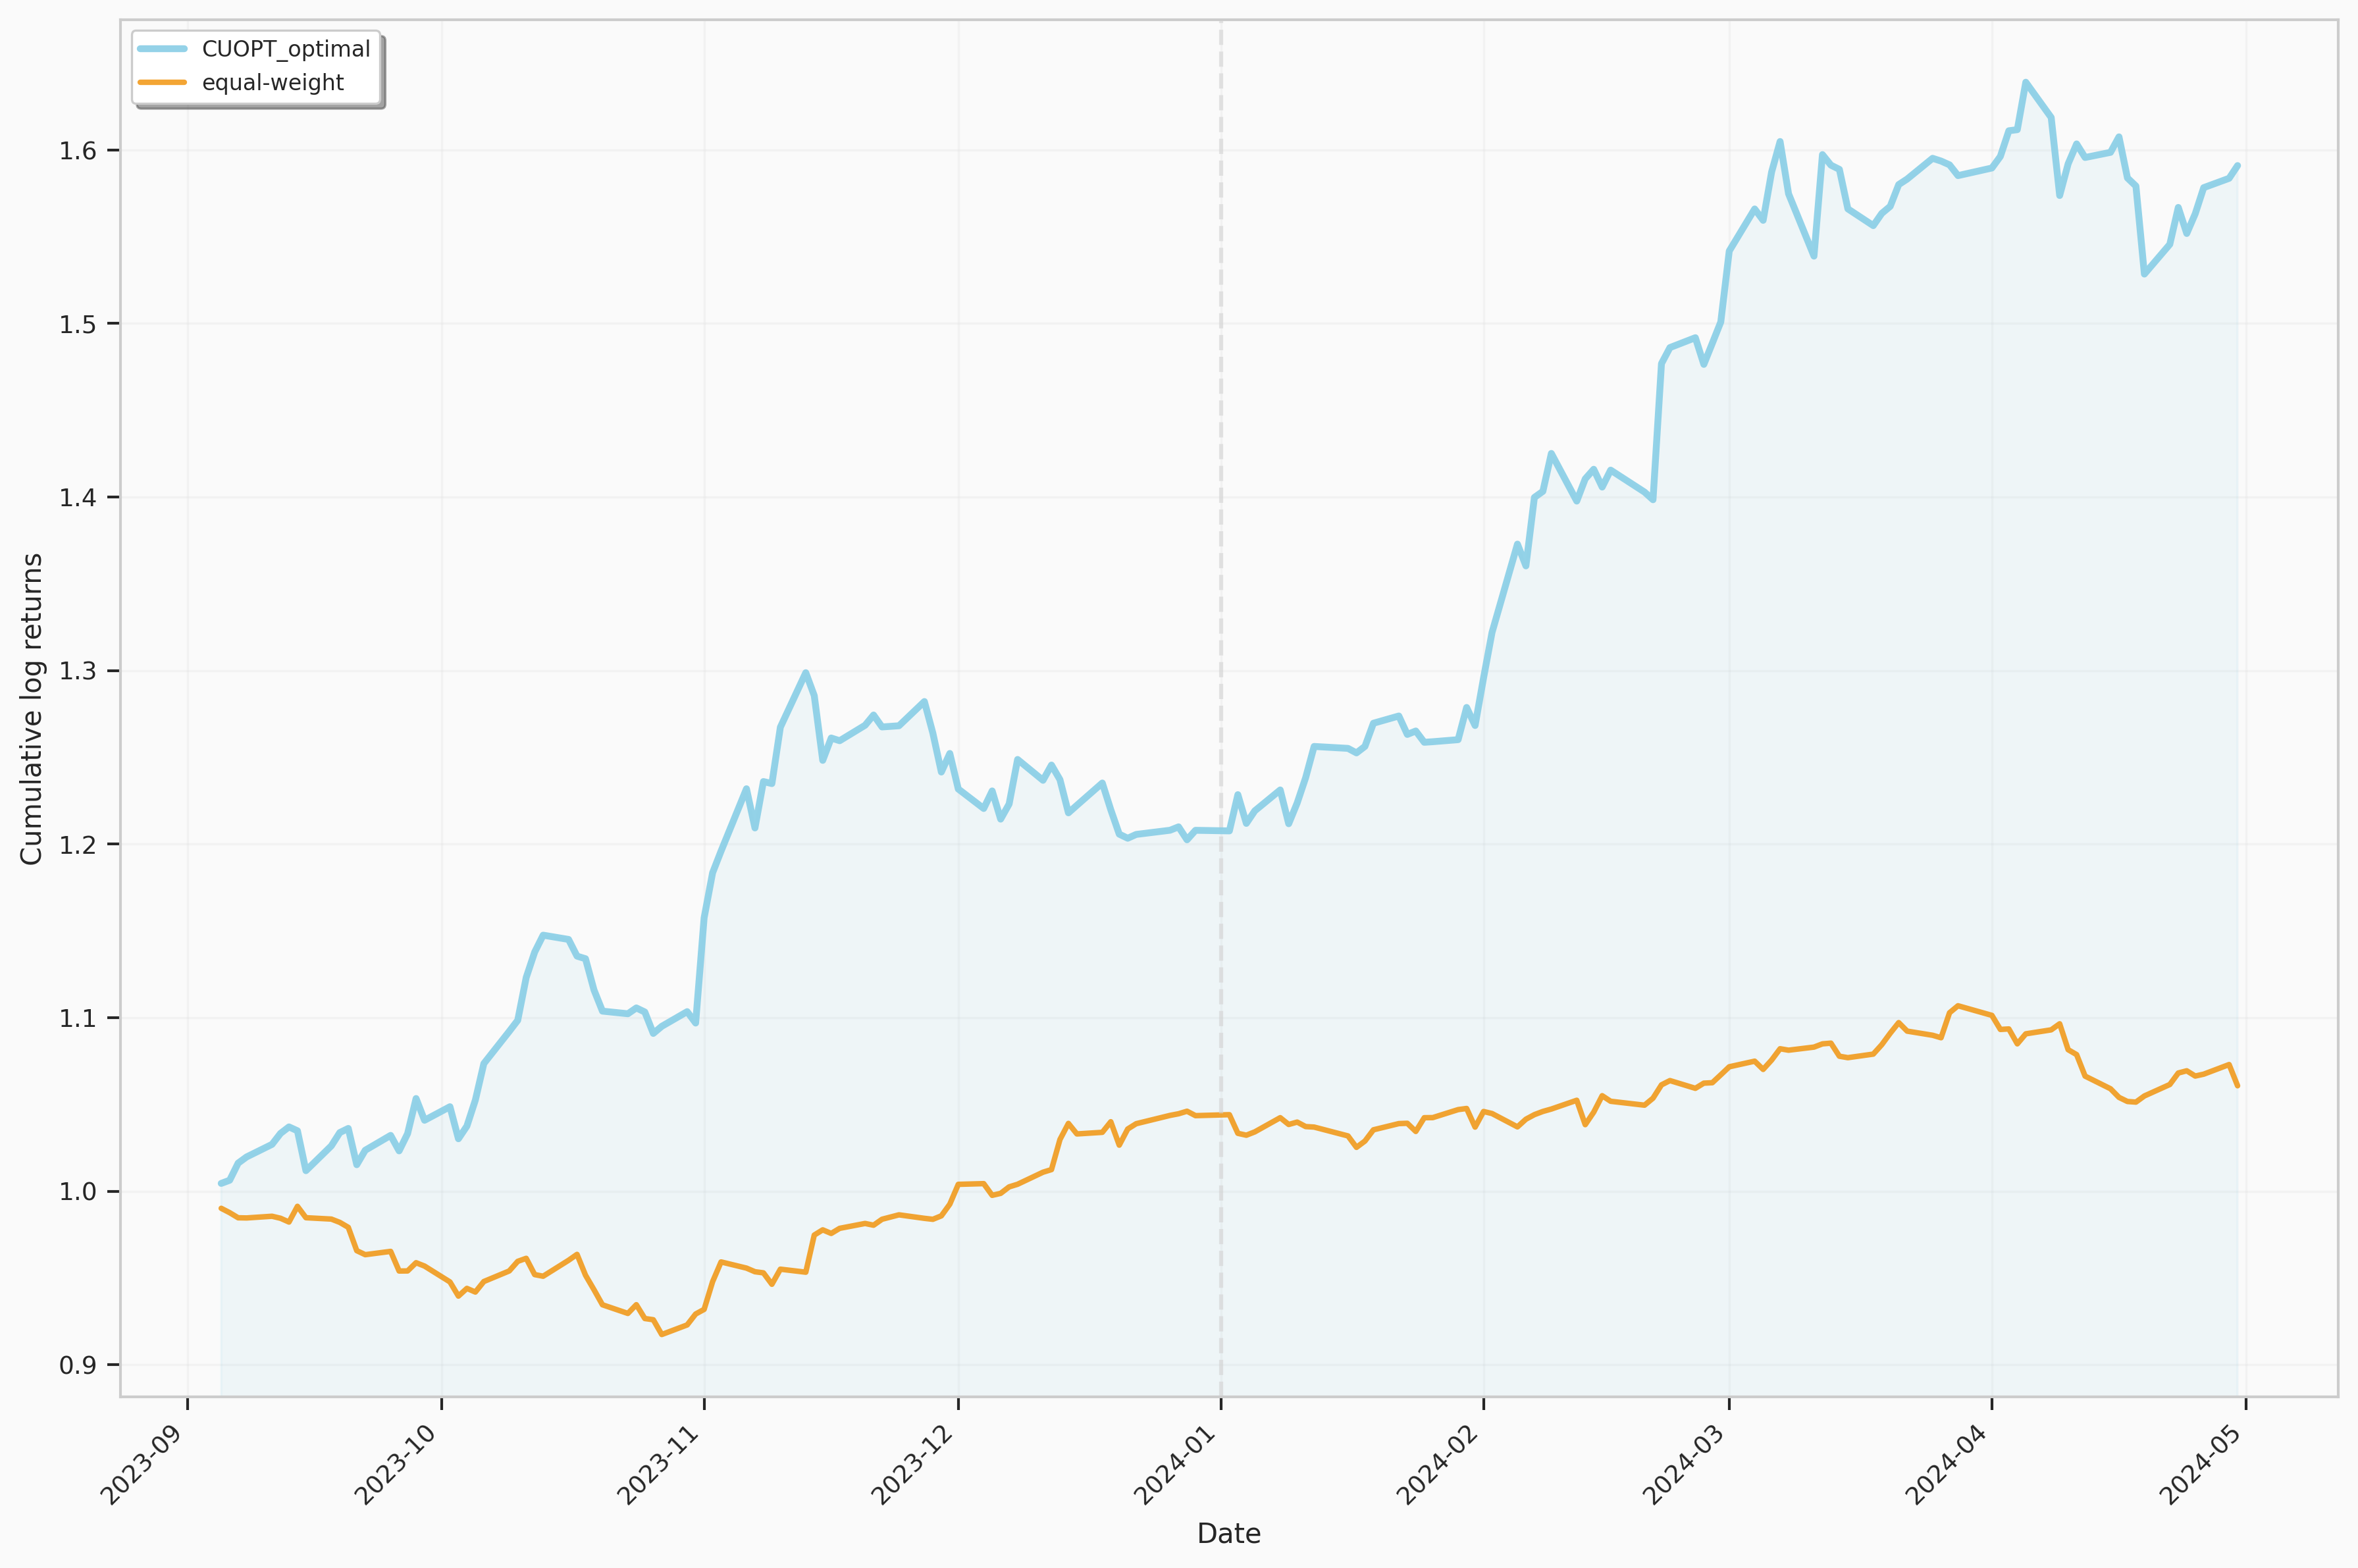

In [ ]:
from cufolio import backtest

cut_off_date = regime_dict["range"][1]

backtester = backtest.portfolio_backtester(gpu_portfolio, test_returns_dict, risk_free, test_method, benchmark_portfolios = None)
backtest_result,_ = backtester.backtest_against_benchmarks(plot_returns = True, cut_off_date = cut_off_date, save_plot = True, results_dir = "../result/backtest")

backtest_result

Combined plot saved: ./result/backtest/combined_cuopt_optimal_historical_analysis.png


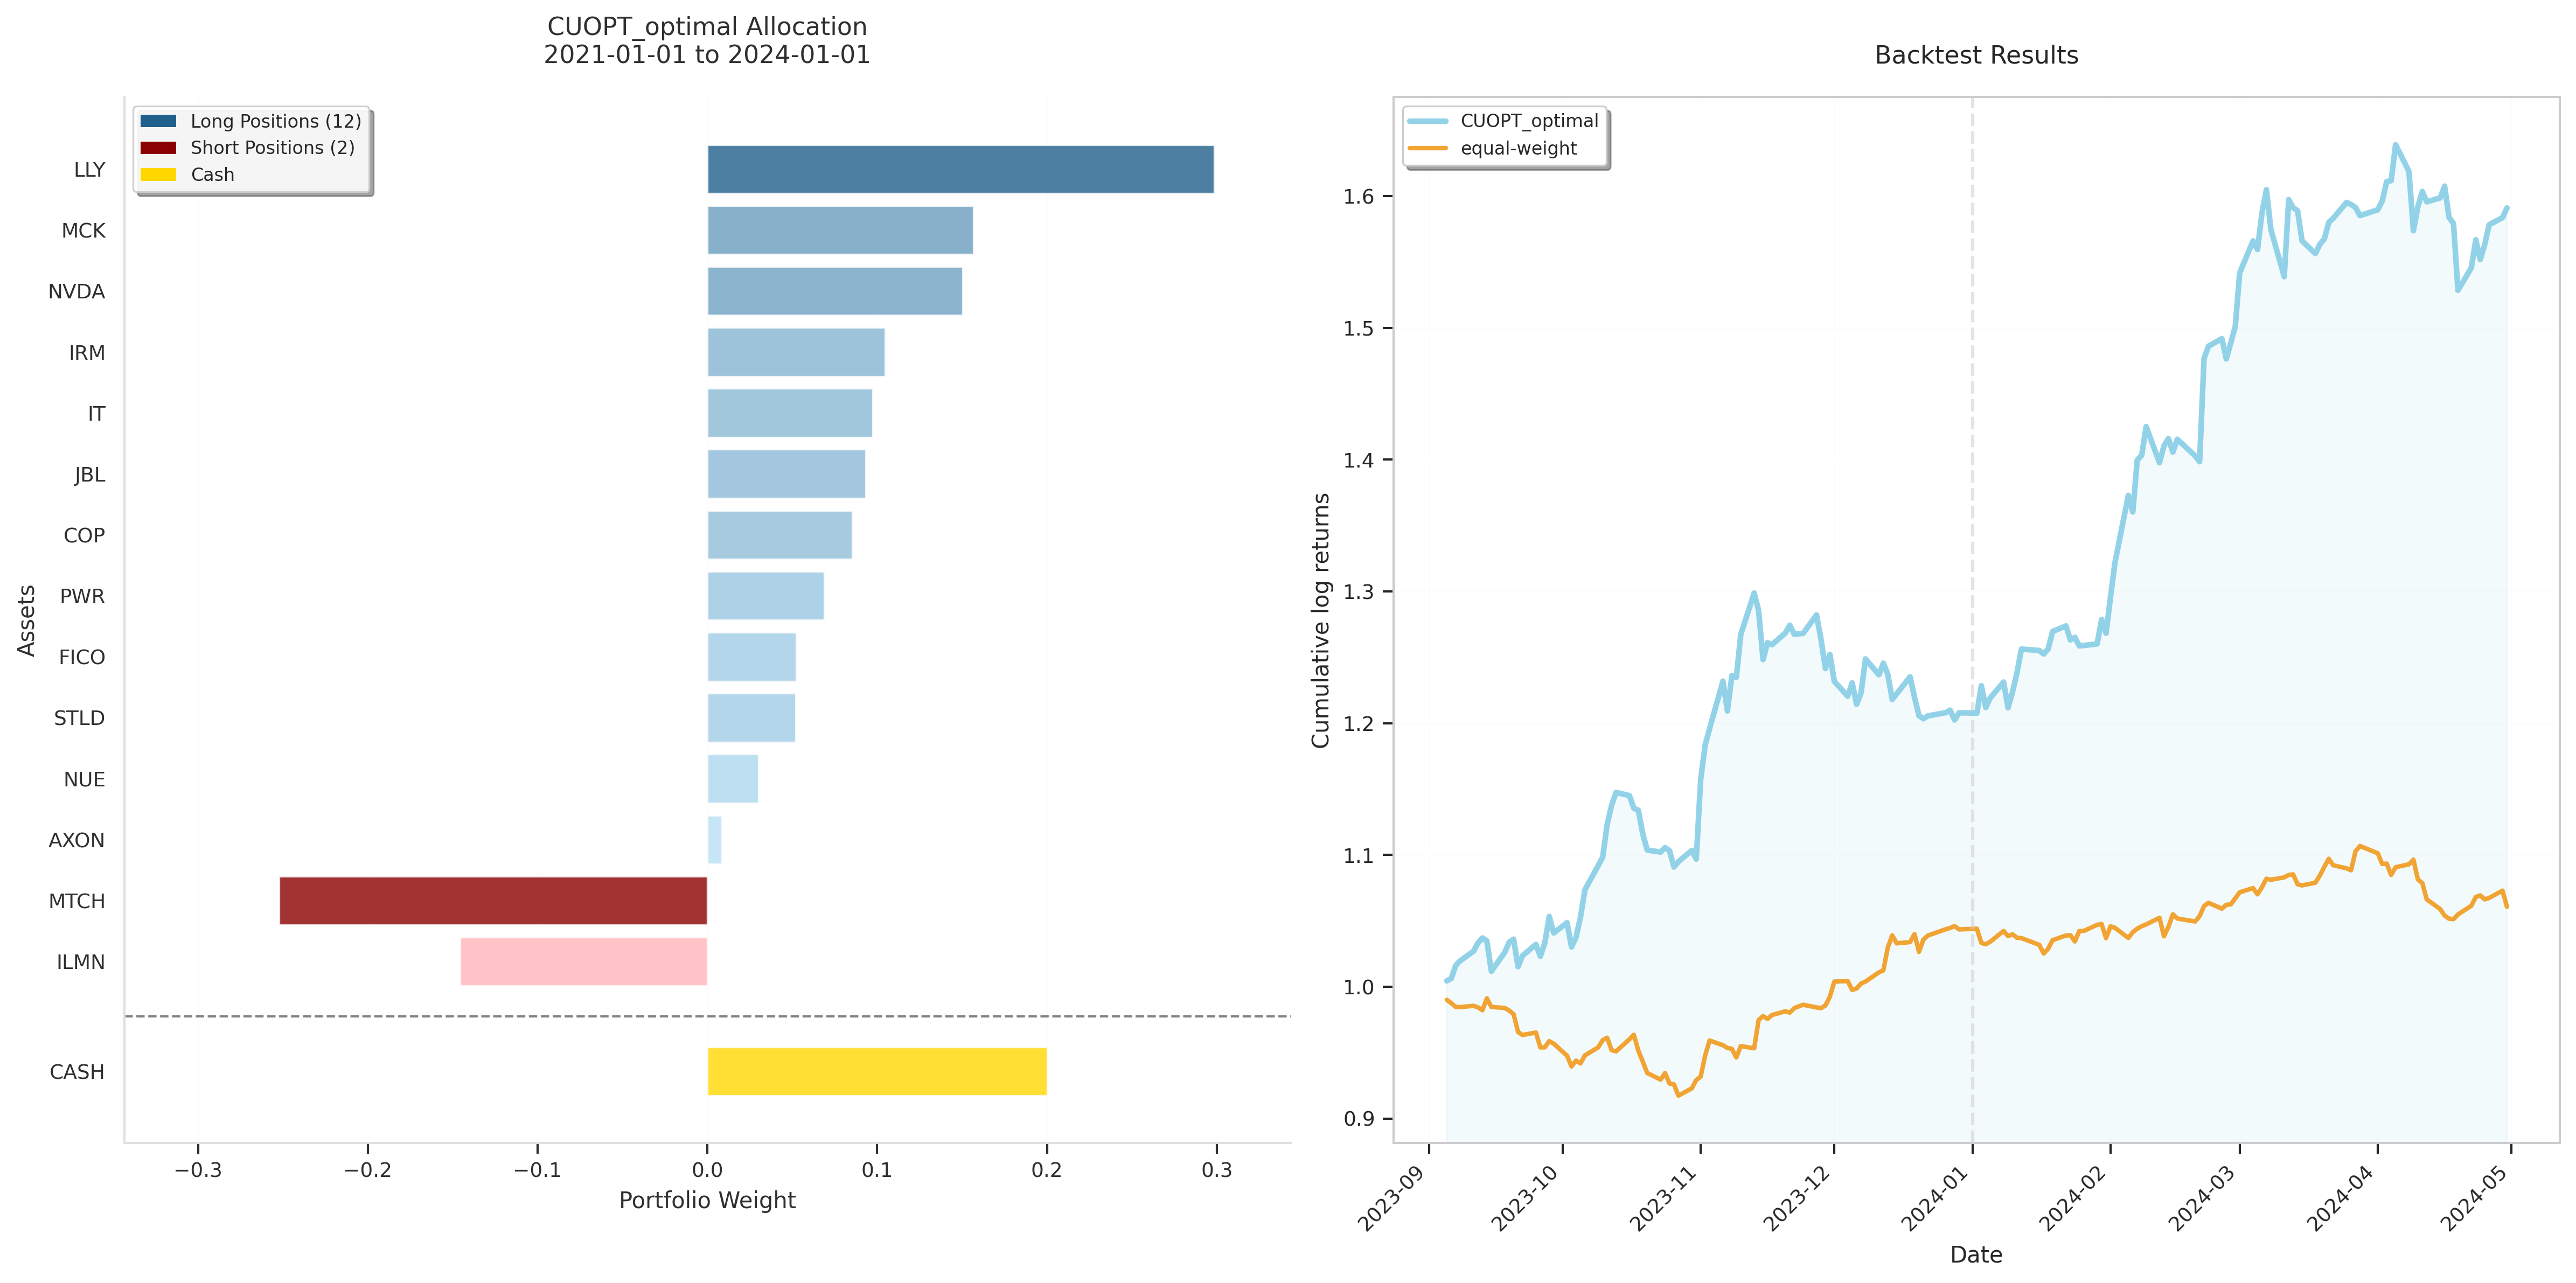

In [ ]:
#plot portfolio and backtest results side by side
utils.portfolio_plot_with_backtest(portfolio=gpu_portfolio, backtester=backtester, cut_off_date= cut_off_date, backtest_plot_title="Backtest Results", save_plot = True, results_dir = "../result/backtest")

## GPU vs. CPU: Comparison over Different Regimes

To further compare the performance of cuOpt GPU solver vs. CPU solvers, we can compare CPU vs. GPU performance over solving the same problems over different market regimes. The function `cvar_utils.optimize_market_regimes` generates Mean-CVaR optimization problems iteratively over different regimes from `regime_comparison_selected_dict`, solve each problem using all the solvers specified in `solver_settings_list`, and returns a dataframe of results. 

In [ ]:
# CVaR parameters for regime comparison
regime_comparison_cvar_params = CvarParameters(
    w_min={"NVDA":0.1, "others": -0.3}, w_max={"NVDA": 0.6, "others": 0.4},        # Asset weight allocation bounds
    c_min=0.0, c_max=0.2,         # Cash holdings bounds
    L_tar=1.6, T_tar=None,        # Leverage & Turnover (None for this example)
    cvar_limit=None,              # Max CVaR (None = unconstrained for this example)
    cardinality = None,             
    risk_aversion=1,              # Risk aversion level
    confidence=0.95,              # CVaR confidence level (alpha)
    num_scen=20000,                # Number of return scenarios to simulate
    fit_type="kde"                # Return distribution estimation method
)

# --- User inputs for Regime Comparison ---
regime_comparison_dataset_name = "sp500"
regime_comparison_return_type = "LOG"

# Prepare output directory & file name
regime_comparison_output_folder = "../result/regime_results"
os.makedirs(regime_comparison_output_folder, exist_ok=True)
regime_comparison_results_csv_path = os.path.join(
    regime_comparison_output_folder,
    f"both_results_{regime_comparison_dataset_name}_{regime_comparison_cvar_params.num_scen}.csv"
)

# Regime settings - OK to customize!
regime_comparison_selected_dict = {
    "pre_crisis"                  : ("2005-01-01", "2007-10-01"),
    "crisis"                      : ("2007-10-01", "2009-04-01"),
    "post_crisis"                 : ("2009-06-30", "2014-06-30"),
    "oil_price_crash"             : ("2014-06-01", "2016-03-01"),
    "FAANG_surge"                 : ("2015-01-01", "2021-01-01"),
    "covid"                       : ("2020-01-01", "2023-01-01"),
    "recent"                      : ("2022-01-01", "2024-07-01")
}

solver_settings_list = [
    {"solver": cp.HIGHS, "verbose": False, "highs_options":{"optimality_tolerance":1e-4}}, 
    {"solver": cp.CLARABEL, "verbose": False},
    {"solver":cp.CUOPT, "verbose": False, "solver_method": "PDLP", "optimality": 1e-4}
]

regime_comparison_dataset_path = f"../data/stock_data/{regime_comparison_dataset_name}.csv"

# Run CPU vs GPU comparison across selected regimes
regime_comparison_results_df = cvar_utils.optimize_market_regimes(
    input_file_name=regime_comparison_dataset_path,
    return_type=regime_comparison_return_type,
    all_regimes=regime_comparison_selected_dict,
    cvar_params=regime_comparison_cvar_params,
    solver_settings_list=solver_settings_list,
    results_csv_file_name=regime_comparison_results_csv_path
)

print(f"Regime comparison results saved to: {regime_comparison_results_csv_path}")
# The regime_comparison_results_df DataFrame will contain performance metrics for both CPU and GPU.
# The optimize_market_regimes function will print intermediate results for each regime and device.

KeyboardInterrupt: 

In [ ]:
regime_comparison_results_df

,regime,cpu_time,gpu_time,cpu_obj,gpu_obj,obj_gap(CPU - GPU),return_gap,CVaR_gap,cpu optimal portfolio,gpu optimal portfolio
0,pre_crisis,70.334936,0.534,-0.001812,-0.001812,-0.0,0.000001,0.000009,"({'AAPL': 0.11977948682165063, 'AMD': -0.05989...","({'AAPL': 0.12030344888373386, 'AMD': -0.06007..."
1,crisis,42.190308,0.922,-0.003795,-0.00379,-0.000005,-0.000013,-0.000901,"({'AIG': -0.17213007000557276, 'AZO': 0.4, 'EW...","({'AIG': -0.17170005380563144, 'AZO': 0.326055..."
2,post_crisis,75.503,0.451,-0.000876,-0.000876,-0.0,-0.0,-0.00001,"({'AAPL': 0.02926625156982806, 'AMD': -0.08027...","({'AAPL': 0.026813274615743926, 'AMD': -0.0796..."
3,oil_price_crash,53.428205,0.506,-0.001894,-0.001895,0.0,-0.000001,-0.00002,"({'AMZN': 0.07515247851949247, 'DPZ': 0.110991...","({'AMZN': 0.07489713615636417, 'DPZ': 0.105937..."
4,FAANG_surge,49.89322,0.734,-0.001033,-0.001033,0.0,-0.0,0.000002,"({'ALGN': 0.06956047318333564, 'AMD': 0.079735...","({'ALGN': 0.06952407948362996, 'AMD': 0.080562..."
5,covid,57.432564,0.664,-0.001366,-0.001366,-0.0,0.0,-0.000009,"({'BBWI': 0.028269858203654012, 'CCL': -0.3, '...","({'BBWI': 0.028893538594851925, 'CCL': -0.3, '..."
6,recent,56.317174,0.566,-0.001527,-0.001526,-0.000001,0.000002,0.000018,"({'AXON': 0.01966583248623681, 'BIO': -0.03103...","({'AXON': 0.020317515795466822, 'BIO': -0.0316..."


## Appendix

### Optional: Parameter Constraints
Optional to define weight and cash constraints as CVXPY parameter for faster iteration. 

In some use cases, there is a need to update the weight and cash constraints while keeping the rest of the original problem (dataset and other constraints), this is the faster way without re-building the entire problem. 

Note that in `cvar_optimizer.py` the weight and cash constraints are defaulted to be variable bounds for the weight variable $\mathbf{w}$ and cash variable $c$, i.e. 
```
self.w = cp.Variable(num_assets, name="weights", bounds=[self.params.w_min, self.params.w_max])
```
because empirically cuOpt LP solver is faster when constraints are set as variable bounds. 

In [ ]:
# Instantiate CVaR optimization problem for the S&P 500 example
api_settings = {
                "api": "cvxpy",  # "cvxpy" or "cuopt_python"
                "weight_constraints_type": "parameter",  # "parameter" or "bounds" (CVXPY only)
                "cash_constraints_type": "parameter",   # "parameter" or "bounds" (CVXPY only)
            }
cvar_problem = cvar_optimizer.CVaR(
    returns_dict=returns_dict,
    cvar_params=cvar_params,
    api_settings=api_settings
)

#solve on GPU
gpu_solver_settings = {"solver":cp.CUOPT, "verbose": False} 
gpu_results, gpu_portfolio = cvar_problem.solve_optimization_problem(solver_settings=gpu_solver_settings)


### Optional: cuOpt Python API
Instead of using CVXPY modeling framework, we can build the problem directly in the cuOpt native python API by choosing `api_settings`.


In [ ]:
# Instantiate CVaR optimization problem for the S&P 500 example
cvar_problem = cvar_optimizer.CVaR(
    returns_dict=returns_dict,
    cvar_params=cvar_params,
    api_settings={"api": "cuopt_python"}
)

cuopt_settings = {"log_to_console":True, "presolve": True}
cuopt_gpu_results, cuopt_gpu_portfolio = cvar_problem.solve_optimization_problem(solver_settings=cuopt_settings)


SPDX-FileCopyrightText: Copyright (c) 2023-2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved. 

SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License");you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0. Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.